In [31]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import re
import cv2

In [111]:
def normal_visualization(N):
    image_row = N.shape[0]
    image_col = N.shape[1]
    # converting the array shape to (w*h) * 3 , every row is a normal vetor of one pixel
    N_map = np.copy(np.reshape(N, (image_row, image_col, 3)))
    # Rescale to [0,1] float number
    N_map = (N_map + 1.0) / 2.0
    plt.figure()
    plt.imshow(N_map)
    plt.title('Normal map')

def depth_visualization(D):
    image_row = D.shape[0]
    image_col = D.shape[1]
    D_map = np.copy(np.reshape(D, (image_row,image_col)))
    # D = np.uint8(D)
    plt.figure()
    plt.imshow(D_map)
    plt.colorbar(label='Distance to Camera')
    plt.title('Depth map')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')

In [227]:
def load_images(image_number, path):
    h,w, _ = np.array(Image.open(f'{path}pic1.bmp')).shape
    images = np.zeros((h, w, image_number))
    for i in range(image_number):
        img = Image.open(f'{path}pic{i+1}.bmp')
        gray_image = ImageOps.grayscale(img)
        images[:, :, i] = np.array(gray_image)

    return images

def load_lightsource(number, path):
    lights = []
    f = open(f'{path}LightSource.txt')
    for i in range(number):
        line = f.readline()
        result = re.findall(r'-?\d+',line)[1:]
        value = list(map(int, result))
        lights.append(value)

    return np.array(lights)

def cal_normal(images, lights):
    height = images[:,:,0].shape[0]
    width = images[:,:,0].shape[1]
    normals = np.zeros((height,width,3))

    for y in range(height):
        for x in range(width):
            I = images[y, x, :]
            # solve Ax = B, in here A = light source, B = intensity vector, and return normal x
            normal, _, _, _ = np.linalg.lstsq(lights, I, rcond=None)
            albedo = np.linalg.norm(normal)
            normals[y][x] = np.divide(normal, albedo, out=np.zeros_like(normal), where=albedo!=0) # prevent divide by zero

    return normals
            

In [133]:
def getSurface(surfaceNormals, method='column'):
    print("surfaceNormals.shape:{}".format(surfaceNormals.shape))

    w = surfaceNormals.shape[1]
    h = surfaceNormals.shape[0]
    heightmap = np.zeros((h, w))
    g1xy = surfaceNormals[:,:,0]
    g2xy = surfaceNormals[:,:,1]
    g3xy = surfaceNormals[:,:,2]
    fx = np.divide(-1 * g1xy, g3xy, out=np.zeros_like(g1xy), where=g3xy!=0)
    fy = np.divide(-1 * g2xy, g3xy, out=np.zeros_like(g2xy), where=g3xy!=0)

    if method == 'column':
        print("method: COLUMN")
        heightmap[:,0] = np.cumsum(fy[:,0], axis=0)
        fx[:,0] = heightmap[:,0]
        heightmap = np.cumsum(fx, axis=1)

        return heightmap
    
    if method == 'row':
        print("method: ROW")
        heightmap[0,:] = np.cumsum(fx[0,:])
        fy[0,:] = heightmap[0,:]
        heightmap = np.cumsum(fy, axis=0)
        return heightmap

    if method == 'average':
        print("method: AVERAGE")
        map_col = np.zeros((h, w))
        map_col[:,0] = np.cumsum(fy[:,0], axis=0)
        fx[:,0] = map_col[:,0]
        map_col = np.cumsum(fx, axis=1)

        map_row = np.zeros((h, w))
        map_row[0,:] = np.cumsum(fx[0,:])
        fy[0,:] = map_row[0,:]
        map_row = np.cumsum(fy, axis=0)

        map_avg = (map_col + map_row) / 2
        return map_avg

surfaceNormals.shape:(120, 120, 3)
method: ROW


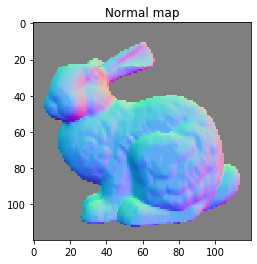

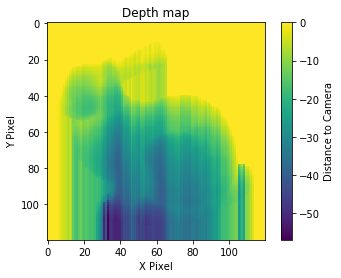

In [240]:
images = load_images(6,"./test/bunny/")
lights = load_lightsource(6,"./test/bunny/")

normal_vector = cal_normal(images, lights)
normal_visualization(normal_vector)
height_map = getSurface(normal_vector)
depth_visualization(height_map)